# The$\ \beta$-Hermite (Gaussian) Ensembles

Referencing paper : <i>Matrix Models for Beta Ensembles</i>, Ioana Dumitriu and Alan Edelman

- Generation of \ \beta$-Hermite Gaussian Ensemble as in the paper
- Plot the DPP created by the matrices of this ensemble
- Finfd a dynamic version, a Dyson Brownian motion version.


In [1]:
%pylab inline
from matplotlib import gridspec
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

def sc_law(x,R=1):
    return 2/(pi*R**2) * np.sqrt(R**2 - x**2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
dim = 4
beta = 1

In [3]:
def beta_Hermite_Gaussian_ensemble(dim, beta):
    diag = np.diag(np.random.randn(dim))
    u_diag_vect = np.zeros(dim-1)
    for i in range(0,dim-1):
        u_diag_vect[i] = np.sqrt(np.random.chisquare((dim-(i+1))*beta))
    u_diag = np.diag(u_diag_vect,1)
    H_b = diag + u_diag + u_diag.T
    return H_b

In [4]:
beta_Hermite_Gaussian_ensemble(dim, beta)

array([[ 1.55950764,  1.03791196,  0.        ,  0.        ],
       [ 1.03791196, -0.87187605,  1.88562158,  0.        ],
       [ 0.        ,  1.88562158,  0.04632176,  0.40970027],
       [ 0.        ,  0.        ,  0.40970027,  1.62948795]])

In [5]:
# Eigenvalues sample
N = 200
eigenvalues_samples = np.linalg.eigvalsh(beta_Hermite_Gaussian_ensemble(N, beta))

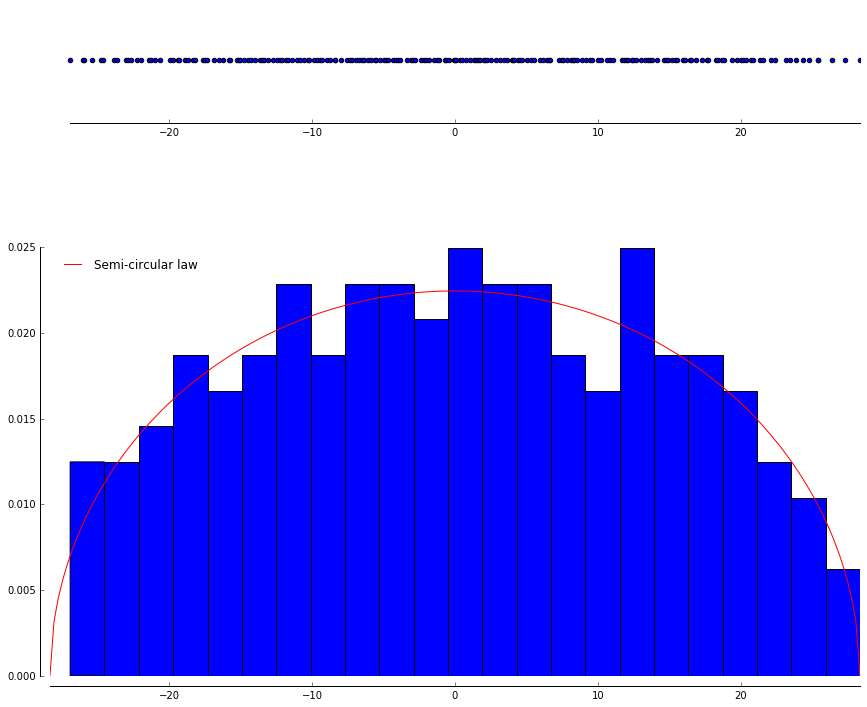

In [6]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(hspace=.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
ax0 = plt.subplot(gs[0])

ax0.scatter(eigenvalues_samples, np.zeros((N,)))
adjust_spines(ax0, ['bottom'])
plt.savefig('beta_hermite_eigenvalues.png', bbox_inches='tight')

# Distribution of the eigen values
# Histo
num_bins = 23
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.hist(eigenvalues_samples, num_bins, normed=1)

# Semi circle law
sc_nb_points = 200
x=np.linspace(-max(eigenvalues_samples),max(eigenvalues_samples),sc_nb_points)
ax1.plot(x,sc_law(x,R=max(eigenvalues_samples)),'red', label=r'Semi-circular law')

# Plot options
ax1.set_xlim([-1*max(eigenvalues_samples), 1*max(eigenvalues_samples)])
plt.subplots_adjust(left=0.15)
ax1.legend(loc='upper left', frameon=False)

adjust_spines(ax1, ['left', 'bottom'])
plt.savefig('beta_hermite_eigenvalues.png', bbox_inches='tight')

In [7]:
class beta_hermite_dpp:
    def __init__(self, n_traj, n_samples, tf, beta, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = tf/n_samples
        self.beta = beta
        #self.dpp_matrix = np.zeros((self.n_samples, self.n_traj, self.n_traj))
        self.dpp_matrix = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag(rescaling)

    def generate(self):
        for sample in range(self.n_samples-1):
            self.dpp_matrix.append(self.dpp_matrix[sample] + \
                beta_Hermite_Gaussian_ensemble(self.n_traj, beta)*(self.dt)**0.5)

    def diag(self, rescaling):
        if rescaling:
            for sample in range(self.n_samples-1):
                eigen_values = \
                    sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample+1])), reverse=True)
                self.eigen_values[sample+1] = np.multiply(eigen_values, 1/np.sqrt((sample+1)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(self.n_samples-1):
                self.eigen_values[sample+1] = \
                    sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample+1])), reverse=True)

    def plot(self):
        data=[]
        for traj in range(self.n_traj):
            traj_trace = go.Scatter(
                x=self.dt*np.array(range(self.n_samples)),
                y=(self.eigen_values.T)[traj],
                mode='lines')
            data.append(traj_trace)
        layout = go.Layout(showlegend=False)
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.init_notebook_mode()
        plotly.offline.iplot(fig)



In [13]:
test_beta_hermite_dpp = beta_hermite_dpp(50, 1000, 1, beta=2)

In [14]:
test_beta_hermite_dpp.plot()

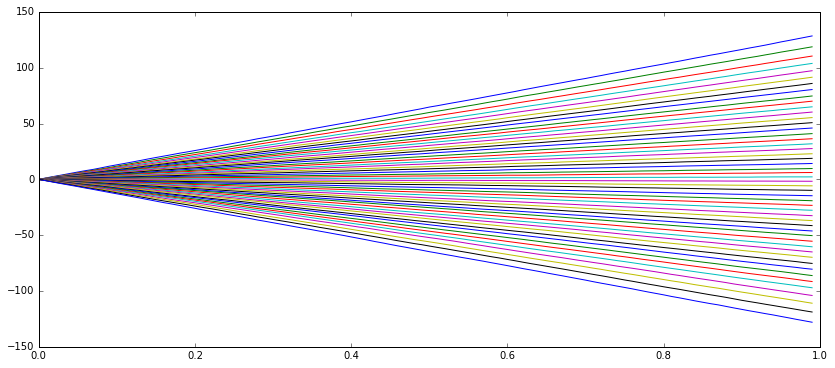

In [10]:
fig = plt.figure(1, figsize=(14, 6))

t = np.matlib.repmat(np.arange(0, test_beta_hermite_dpp.tf, test_beta_hermite_dpp.dt),test_beta_hermite_dpp.n_traj,1)
plt.plot(t.T, test_beta_hermite_dpp.eigen_values)
plt.show()

In [12]:
test_beta_hermite_dpp.dpp_matrix[9]

array([[ 0.28008643,  6.35932095,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.35932095, -0.02159155,  6.24154595, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  6.24154595,  0.41819608, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ..., -0.07739356,
         1.23102715,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.23102715,
         0.38473375,  0.74446231],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.74446231,  0.01580159]])